# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [31]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets for us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [32]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [33]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


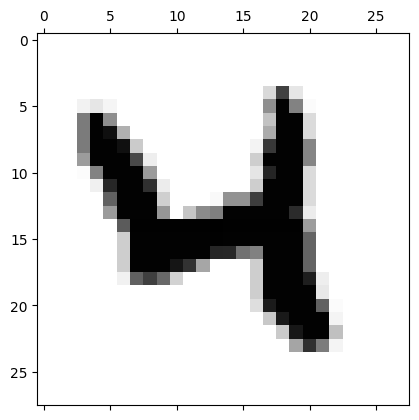

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [34]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy (it's a classification task!)
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [36]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model with SGD optimizer
    # model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(), metrics=['acc'])
    # compile the model with Adagrad optimizer
    # model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adagrad(), metrics=['acc'])
    # compile the model with Adam optimizer
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [37]:
# training parameters
batch_size = 32
epochs = 50

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.8580 - loss: 0.4765 - val_acc: 0.9683 - val_loss: 0.1011
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9609 - loss: 0.1376 - val_acc: 0.9713 - val_loss: 0.0946
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9718 - loss: 0.0954 - val_acc: 0.9768 - val_loss: 0.0773
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9786 - loss: 0.0713 - val_acc: 0.9784 - val_loss: 0.0747
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.9817 - loss: 0.0617 - val_acc: 0.9757 - val_loss: 0.0825
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9851 - loss: 0.0475 - val_acc: 0.9769 - val_loss: 0.0890
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9868 - loss: 0.0428 - val_acc: 0.9778 - val_loss: 0.0865
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9888 - loss: 0.0364 - val_acc: 0.9788 - val_loss: 0.0948
Epoch 9/50
1875/1875 ━━━━━━━━━━━

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9781 - loss: 0.2711

Test loss: 0.20021019876003265
Test accuracy: 0.982200026512146


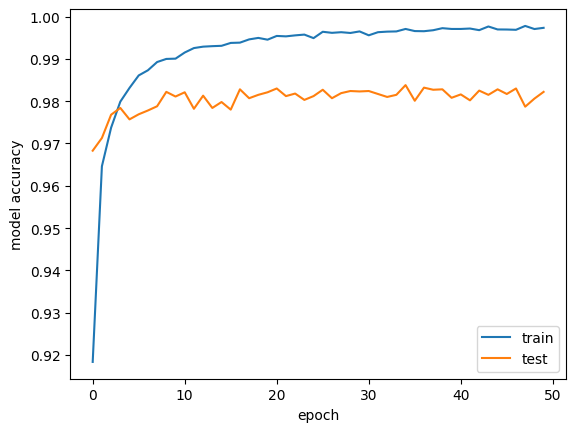

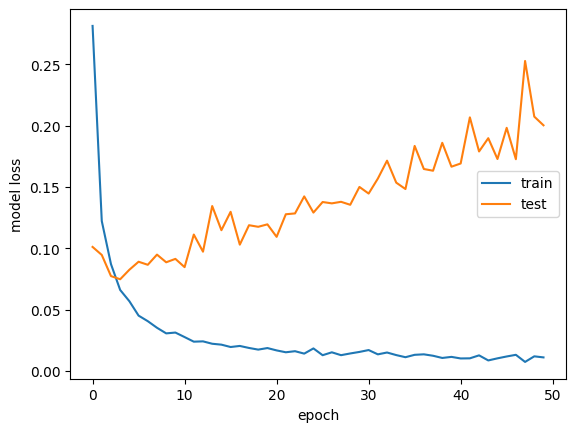

In [39]:
import json

# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Salva i dati della cronologia del training in un file JSON
history_data = {
    'accuracy': history.history['acc'],
    'val_accuracy': history.history['val_acc'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'test_loss': score[0],
    'test_accuracy': score[1]
}

with open('adam.json', 'w') as f:
    json.dump(history_data, f)

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

In [10]:
# Before re-executing after the first time, we need to reshape X_test
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


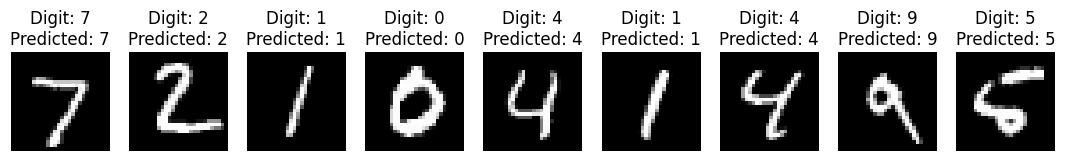

In [11]:
predictions = model_DNN.predict(X_test)

# reshape X_test in (img, rows, cols, channel=grey scales)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(9):    
    ax = plt.subplot(2, 10, i + 1) # create substructur in figure
    plt.imshow(X_test[i, :, :, 0], cmap='gray') # show image
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # show digit and predicted digit
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

I exploted the previous code to write files containg data about accuracy and loss for training and validation data. Here I show the difference between optimizers. I always used 50 epochs to better compare.

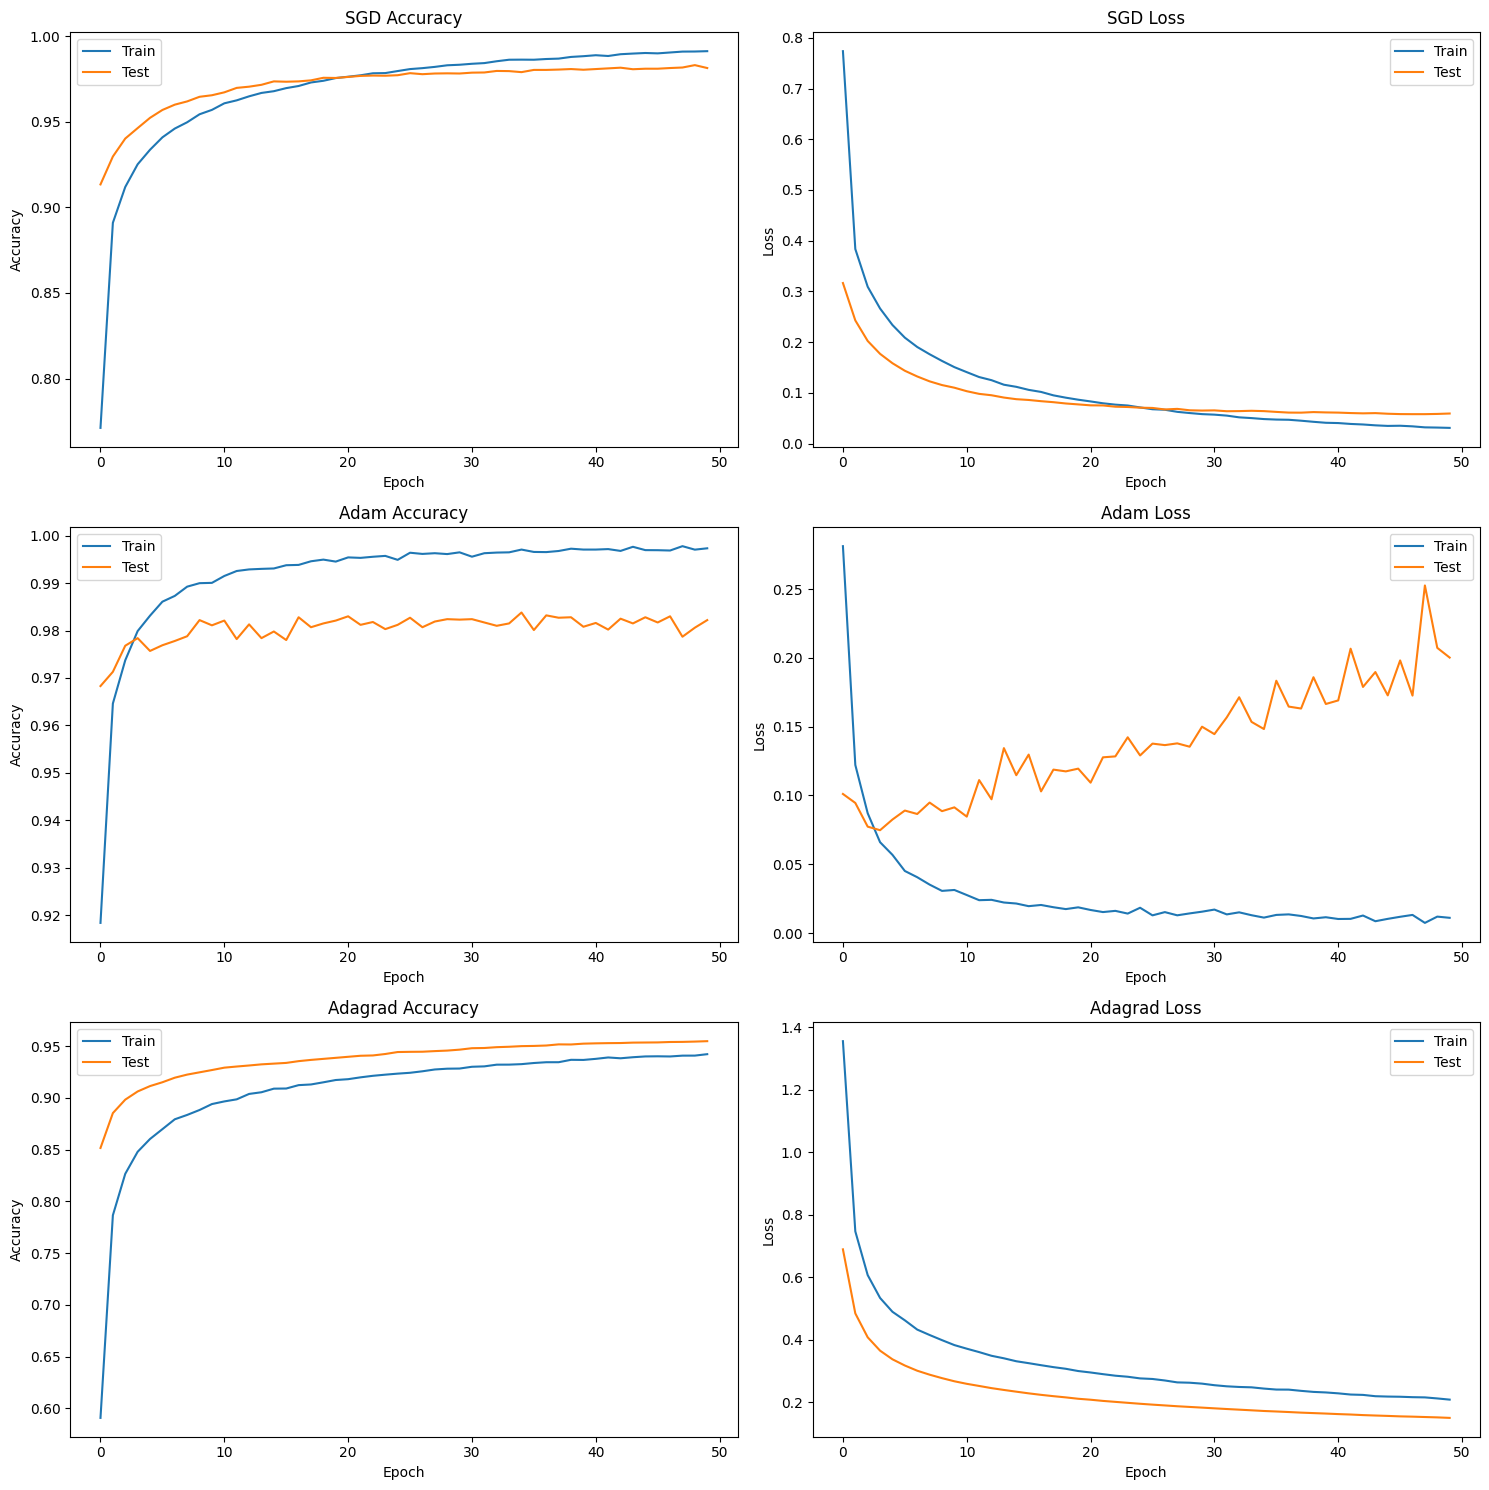

In [40]:
# Funzione per caricare i dati da un file JSON
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Carica i dati dai file JSON utilizzando numpy
sgd_history = load_json('sgd.json')
adam_history = load_json('adam.json')
adagrad_history = load_json('adagrad.json')

# Crea un grafico a 3 righe e 2 colonne
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Definisci i nomi per i plot
plot_names = [('SGD', sgd_history), ('Adam', adam_history), ('Adagrad', adagrad_history)]

# Itera su ogni ottimizzatore e crea i grafici
for i, (optimizer, history) in enumerate(plot_names):
    axes[i, 0].plot(history['accuracy'])
    axes[i, 0].plot(history['val_accuracy'])
    axes[i, 0].set_ylabel('Accuracy')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].legend(['Train', 'Test'], loc='best')
    axes[i, 0].set_title(f'{optimizer} Accuracy')

    axes[i, 1].plot(history['loss'])
    axes[i, 1].plot(history['val_loss'])
    axes[i, 1].set_ylabel('Loss')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].legend(['Train', 'Test'], loc='best')
    axes[i, 1].set_title(f'{optimizer} Loss')

# Aggiusta il layout
plt.tight_layout()
plt.show()

It is interesting to observe that different optimizer have different behaviour. As we can see, in Adagrad pictures validation_loss is always less than training_loss, this means that $50$ epochs are not enough, there's still room for improvement, in fact the accuracy are lower compared to other optimizers that passed beyong the point of overlearning.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [41]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D, Input

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

In [42]:
def create_CNN():
    
    # instantiate model
    model = Sequential()

    # Input level: "When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model"
    model.add(Input(shape=input_shape))
    
    # add first convolutional layer with 10 filters (dimensionality of output space) of size 5x5 with relu activation
    # input: 28x28x1 (28x28 pixels and 1 channel)
    # output: 24x24x10 (1+(W-F+2P)/S = 24, W=input width=28, F=filter=5, P=padding=0, S=stride=1
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu'))

    # max pooling with pool_size 2x2 takes squares with l=2 and sobstitute them with the higher value in the square
    # columns as well as raws are reduced by a factor 2: 12x12x10
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # input: 12x12x10. output: 8x8x20
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu'))
    
    # output: 4x4x20
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # apply dropout with rate 0.5 to reduce overfitting
    model.add(Dropout(0.2))

    # unroll (flatten) the previous parameters: 4x4x20=320 
    model.add(Flatten())

    # standard all-to-all connected layer
    model.add(Dense(128, activation='relu'))

    # final soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


Train your DCNN and evaluate its performance proceeding exactly as before:

In [43]:
# training parameters
batch_size = 32
epochs = 20

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - acc: 0.6262 - loss: 1.1336 - val_acc: 0.9528 - val_loss: 0.1550
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - acc: 0.9412 - loss: 0.1961 - val_acc: 0.9706 - val_loss: 0.0943
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - acc: 0.9571 - loss: 0.1422 - val_acc: 0.9768 - val_loss: 0.0758
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - acc: 0.9656 - loss: 0.1164 - val_acc: 0.9804 - val_loss: 0.0629
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9685 - loss: 0.1022 - val_acc: 0.9827 - val_loss: 0.0564
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - acc: 0.9717 - loss: 0.0924 - val_acc: 0.9842 - val_loss: 0.0530
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - acc: 0.9747 - loss: 0.0834 - val_acc: 0.9847 - val_loss: 0.0473
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - acc: 0.9767 - loss: 0.0771 - val_acc: 0.9852 - val_loss: 0.0465
Epoch 9/20
1875/1875 ━━━

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

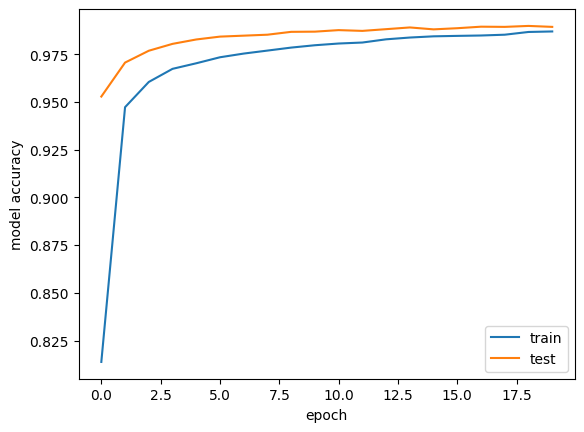

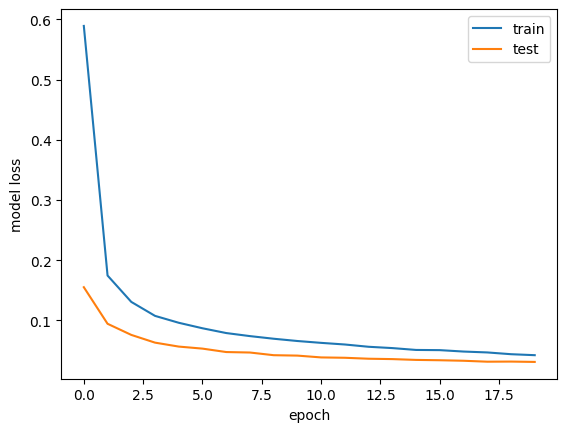

In [44]:
# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [56]:
# Before re-executing after the first time, we need to reshape X_test
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


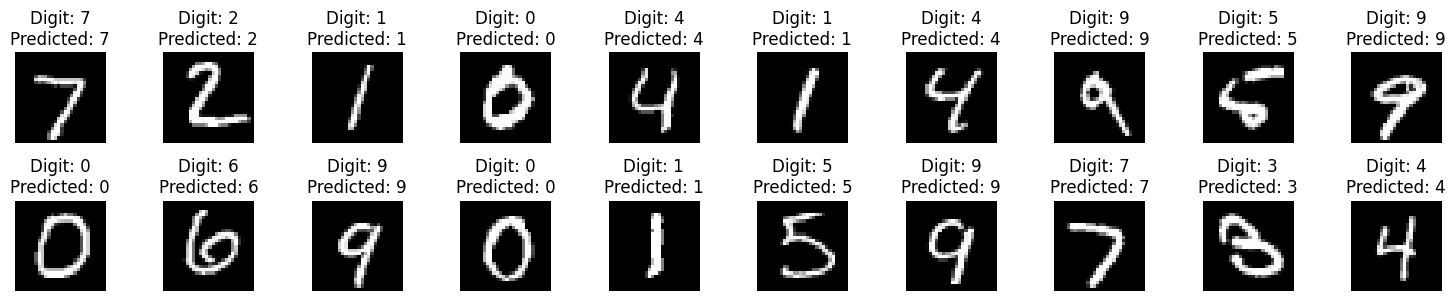

In [45]:
predictions = model_CNN.predict(X_test)

# reshape X_test in (img, rows, cols, channel=grey scales)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

plt.figure(figsize=(15, 15)) 
for i in range(20):    
    ax = plt.subplot(10, 10, i + 1) # create substructur in figure
    plt.imshow(X_test[i, :, :, 0], cmap='gray') # show image
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # show digit and predicted digit
    plt.axis('off') 
plt.tight_layout()
plt.show()

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

Image size: 28x28


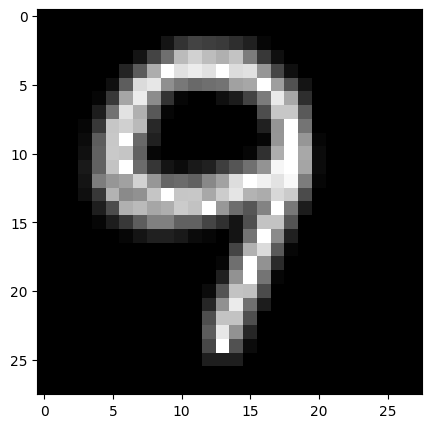

(28, 28)


In [46]:
from PIL import Image
import os

digit_filename = "digit_9.png"
digit_in = Image.open(digit_filename).convert('L')
#digit_in = Image.open("8b.png").convert('L') #ON GOOGLE COLAB INSERT THE NAME OF THE UPLOADED FILE

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load();
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

plt.figure(figsize=(5,5))
plt.imshow(data, cmap='gray')
plt.show()

print(data.shape)

I use the previously trained CNN to predict the digit:

(28, 28)
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


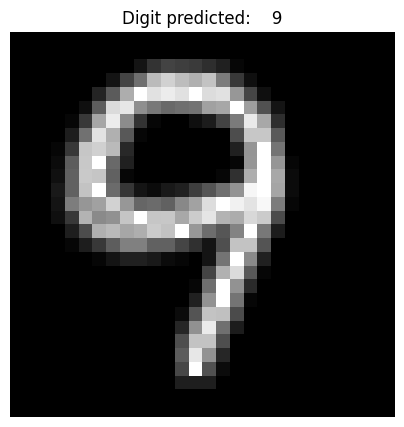

In [47]:
print(data.shape)
data = data.reshape(1,xdim,ydim,1)
print(data.shape)
pred_0 = model_CNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


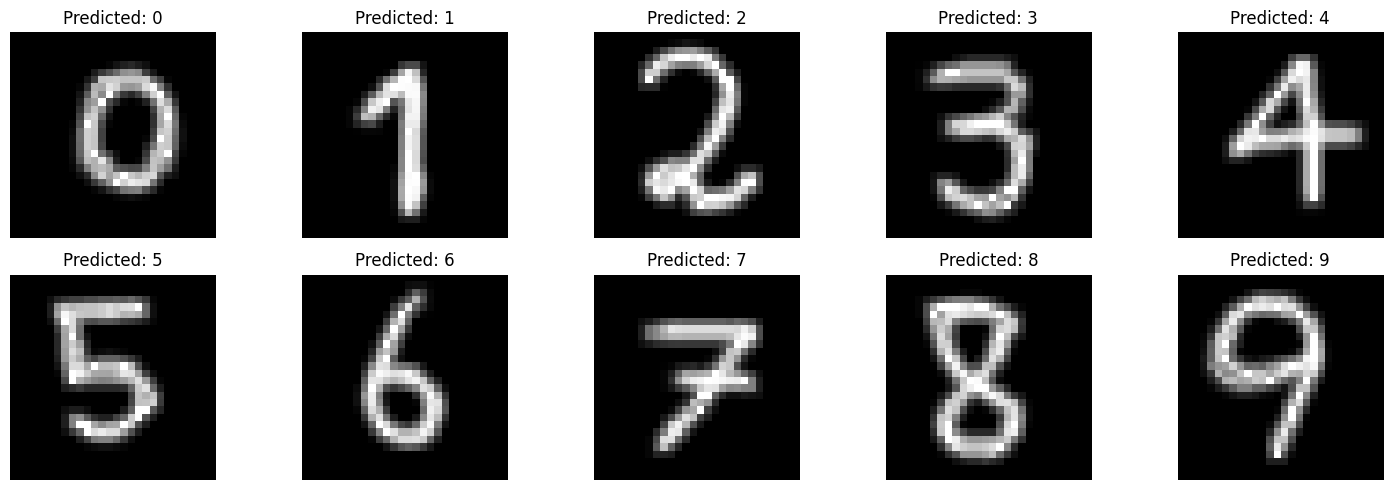

In [48]:
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a figure with multiple subplots arranged in a single row
plt.figure(figsize=(15, 5))

# Loop through each digit and plot the prediction
for idx, digit in enumerate(digits, start=1):
    # Load the digit image and preprocess it
    digit_filename = f"digit_{digit}.png"
    digit_in = Image.open(digit_filename).convert('L') # convert to grayscale
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]

    data /= 255

    # Reshape the data and make prediction
    data = data.reshape(1, xdim, ydim, 1)
    pred = model_CNN.predict(data)

    # Reshape the data for visualization
    data = data.reshape(xdim, ydim)

    # Plot the digit and its predicted label in a subplot
    plt.subplot(2, 5, idx)
    plt.imshow(data, cmap='gray')
    plt.title(f"Predicted: {np.argmax(pred)}")
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [ ]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

Display your filters:

In [ ]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [ ]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer